In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import copy

greens = matplotlib.cm.get_cmap('Greens')
reds = matplotlib.cm.get_cmap('Reds')
blues = matplotlib.cm.get_cmap('Blues')

In [2]:
# Read food balance sheets. To be replaced by
# from agrifoodpy.food import FAOSTAT
data_file = '../../data/food/FoodBalanceSheets_E_All_Data_(Normalized).csv'
# data_file = 'C:/Users/Sarah Bridle/Dropbox/scratch/food/FAOSTAT/dl_20220511/FoodBalanceSheets_E_All_Data_(Normalized).csv'

# We use the food groups defined in the PN18.csv file.
# To be replaced by some other food grouping strategy
pn18_file = '../../data/food/PN18.csv'

# TO-DO CHANGE TO REGION STRING:
# Instead of using a code to identify areas, it could be useful to use a string search based area selection
# i.e. search_region('Great Britain') returns "United Kingdom of Great Britain and Northern Ireland"
# or,  search_region('chile') returns "Chile"

# Impact of change on production vs imports on nutrient intake and emissions by system element and food group

In this example we plot the nutrient and energy intake and emissions per food group, per person per day from FAOSTAT data for several food system proceses.
We then recompute these dissagregations by scaling the relative fraction of imports vs local production for specific food groups


In [3]:
# Fraction of actual production values for animal and plant food products
plant_production_scaling = 1.2
animal_production_scaling = 1.2

In [4]:
# area = 10 #Australia
area = 229 #UK

# Select a year from the 2010-2019 range
year = 2019

In [5]:
pn18 = pd.read_csv(pn18_file, sep=':')

item_codes = pn18['code'].to_numpy()
item_names = pn18['name'].to_numpy()
item_emissions = pn18['mean_emissions'].to_numpy()

fbs = pd.read_csv(data_file, encoding = 'latin1')

pop = fbs[(fbs['Year'] == 2019) & 
          (fbs['Area Code'] == area) &
          (fbs['Element Code'] == 511)]['Value'].values * 1000

fbs = fbs[(fbs['Year'] == year) & (fbs['Area Code'] == area)].drop(['Area Code', 'Area', 'Year Code', 'Flag'], axis=1)
fbs = fbs[fbs['Item Code'].isin(item_codes)]

for code, name in zip(item_codes, item_names):
    print(code, name)

2731 Bovine Meat
2732 Mutton & Goat Meat
2733 Pigmeat
2734 Poultry Meat
2735 Meat, Other
2736 Offals, Edible
2744 Eggs
2740 Butter, Ghee
2743 Cream
2848 Milk - Excluding Butter
2511 Wheat and products
2513 Barley and products
2514 Maize and products
2515 Rye and products
2516 Oats
2520 Cereals, Other
2531 Potatoes and products
2534 Roots, Other
2535 Yams
2807 Rice and Products
2546 Beans
2547 Peas
2549 Pulses, Other and products
2555 Soyabeans
2543 Sweeteners, Other
2558 Rape and Mustardseed
2570 Oilcrops, Other
2571 Soyabean Oil
2572 Groundnut Oil
2573 Sunflowerseed Oil
2574 Rape and Mustard Oil
2576 Palmkernel Oil
2577 Palm Oil
2578 Coconut Oil
2579 Sesameseed Oil
2580 Olive Oil
2582 Maize Germ Oil
2586 Oilcrops Oil, Other
2745 Honey
2551 Nuts and products
2552 Groundnuts (Shelled Eq)
2560 Coconuts - Incl Copra
2561 Sesame seed
2775 Aquatic Plants
2563 Olives (including preserved)
2601 Tomatoes and products
2602 Onions
2611 Oranges, Mandarines
2612 Lemons, Limes and products
2613 Gra

In [6]:
element_codes = pd.unique(fbs['Element Code'])
element_codes[[2,3]] = element_codes[[3,2]] # Swap stock and export for visual clarity
quantity_codes = element_codes[element_codes > 5000]

for code in element_codes:
    if code in quantity_codes:
        print(code, fbs[fbs['Element Code'] == code]['Element'].iloc[0], "*")
    else:
        print(code, fbs[fbs['Element Code'] == code]['Element'].iloc[0])

5511 Production *
5611 Import Quantity *
5911 Export Quantity *
5072 Stock Variation *
5301 Domestic supply quantity *
5521 Feed *
5527 Seed *
5123 Losses *
5131 Processing *
5154 Other uses (non-food) *
5170 Residuals *
5142 Food *
645 Food supply quantity (kg/capita/yr)
664 Food supply (kcal/capita/day)
674 Protein supply quantity (g/capita/day)
684 Fat supply quantity (g/capita/day)


In [7]:
# Sort to plants, animals, other
order = np.concatenate((np.arange(4,9), [0, 1, 2, 3, 10], [9, 11]))

group_names = pd.unique(pn18['group'])[order]
group_codes = [pn18.iloc[np.where(pn18['group_id'] == gid)]['code'].to_numpy() for gid in order]

for name, codes in zip(group_names, group_codes):
    print(name, codes)

Cereals, starch [2511 2513 2514 2515 2516 2520 2531 2534 2535 2807]
Pulses [2546 2547 2549 2555]
Sugar, veg. oil [2543 2558 2570 2571 2572 2573 2574 2576 2577 2578 2579 2580 2582 2586
 2745]
Nuts, seeds [2551 2552 2560 2561]
Vegetables, fruits [2775 2563 2601 2602 2611 2612 2613 2614 2615 2616 2617 2618 2619 2620
 2641]
Ruminant Meat [2731 2732]
Other Meat [2733 2734 2735 2736]
Egg [2744]
Dairy [2740 2743 2848]
Fish, seafood [2761 2762 2763 2764 2765 2766 2767 2769]
Other [2630 2633 2635 2640 2642 2645 2655 2656 2657 2658 2680 2737]
Non-food [2781 2782 2575]


In [8]:
# Food groups are classified into plant and animal origin

plant_mask = np.arange(5)
animal_mask = np.arange(5, 10)
other_mask = np.arange(10, 12)

print("Plant based groups:", group_names[plant_mask])
print("Animal based groups:", group_names[animal_mask])
print("Other groups:", group_names[other_mask])

green_colors = greens(1/(2+plant_mask))
red_colors = reds(1/(2+animal_mask-5))
blue_colors = blues([0.5,1])

colors = np.concatenate((green_colors, red_colors, blue_colors))

Plant based groups: ['Cereals, starch' 'Pulses' 'Sugar, veg. oil' 'Nuts, seeds'
 'Vegetables, fruits']
Animal based groups: ['Ruminant Meat' 'Other Meat' 'Egg' 'Dairy' 'Fish, seafood']
Other groups: ['Other' 'Non-food']


In [9]:
# First, insert dummy columns with the new unit definitions

value = fbs['Value'].values
unit = fbs['Unit'].values

new_units = ['kcal/capita/day', 'gprot/capita/day', 'gfat/capita/day', 'g/capita/day', 'kg CO2e/capita/day']

for i, new_unit in enumerate(new_units):

    fbs.insert(len(fbs.columns), f'Unit{i+2}', unit)
    fbs[f'Value{i+2}'] = 0
    
    fbs.loc[fbs[f'Unit{i+2}'] == '1000 tonnes', f'Unit{i+2}'] = new_unit
    fbs.loc[fbs[f'Unit{i+2}'] == 'kg', f'Unit{i+2}'] = 'g/capita/day'

# Let's take a look at one example item
fbs[fbs['Item Code'] == 2731]

,Item Code,Item,Element Code,Element,Year,Unit,Value,Unit2,Value2,Unit3,Value3,Unit4,Value4,Unit5,Value5,Unit6,Value6
2273241,2731,Bovine Meat,5511,Production,2019,1000 tonnes,914.00,kcal/capita/day,0,gprot/capita/day,0,gfat/capita/day,0,g/capita/day,0,kg CO2e/capita/day,0
2273251,2731,Bovine Meat,5611,Import Quantity,2019,1000 tonnes,397.00,kcal/capita/day,0,gprot/capita/day,0,gfat/capita/day,0,g/capita/day,0,kg CO2e/capita/day,0
2273261,2731,Bovine Meat,5072,Stock Variation,2019,1000 tonnes,8.00,kcal/capita/day,0,gprot/capita/day,0,gfat/capita/day,0,g/capita/day,0,kg CO2e/capita/day,0
2273271,2731,Bovine Meat,5911,Export Quantity,2019,1000 tonnes,188.00,kcal/capita/day,0,gprot/capita/day,0,gfat/capita/day,0,g/capita/day,0,kg CO2e/capita/day,0
2273281,2731,Bovine Meat,5301,Domestic supply quantity,2019,1000 tonnes,1116.00,kcal/capita/day,0,gprot/capita/day,0,gfat/capita/day,0,g/capita/day,0,kg CO2e/capita/day,0
2273283,2731,Bovine Meat,5123,Losses,2019,1000 tonnes,0.00,kcal/capita/day,0,gprot/capita/day,0,gfat/capita/day,0,g/capita/day,0,kg CO2e/capita/day,0
2273293,2731,Bovine Meat,5131,Processing,2019,1000 tonnes,0.00,kcal/capita/day,0,gprot/capita/day,0,gfat/capita/day,0,g/capita/day,0,kg CO2e/capita/day,0
2273307,2731,Bovine Meat,5170,Residuals,2019,1000 tonnes,0.00,kcal/capita/day,0,gprot/capita/day,0,gfat/capita/day,0,g/capita/day,0,kg CO2e/capita/day,0
2273317,2731,Bovine Meat,5142,Food,2019,1000 tonnes,1116.00,kcal/capita/day,0,gprot/capita/day,0,gfat/capita/day,0,g/capita/day,0,kg CO2e/capita/day,0
2273327,2731,Bovine Meat,645,Food supply quantity (kg/capita/yr),2019,kg,16.52,g/capita/day,0,g/capita/day,0,g/capita/day,0,g/capita/day,0,g/capita/day,0


In [10]:
for ic, icode in enumerate(item_codes):

    kton_year = fbs.loc[(fbs['Element Code'] == 5142) &
                            (fbs['Item Code'] == icode), 'Value'].values
    
    g_day = kton_year * 1e9 / pop / 365
    
    kcal_day = fbs.loc[(fbs['Element Code'] == 664)&
                            (fbs['Item Code'] == icode), 'Value'].values
    prot_day = fbs.loc[(fbs['Element Code'] == 674)&
                            (fbs['Item Code'] == icode), 'Value'].values
    fat_day = fbs.loc[(fbs['Element Code'] == 684)&
                            (fbs['Item Code'] == icode), 'Value'].values
    
    kcal_g = kcal_day / g_day
    prot_g = prot_day / g_day
    fat_g = fat_day / g_day
    
    for qcode in quantity_codes:
        
        index = fbs.index[(fbs['Item Code'] == icode) & (fbs['Element Code'] == qcode)]
        qty = fbs.loc[(fbs['Item Code'] == icode) & (fbs['Element Code'] == qcode)]['Value'].values
        
        try:
            fbs.loc[index,'Value2'] = qty * kcal_g * 1e9 / pop / 365
            fbs.loc[index,'Value3'] = qty * prot_g * 1e9 / pop / 365
            fbs.loc[index,'Value4'] = qty * fat_g * 1e9 / pop / 365
            fbs.loc[index,'Value5'] = qty * 1e9 / pop / 365
            fbs.loc[index,'Value6'] = qty * 1e6 / pop / 365 * item_emissions[ic]
        except ValueError:
            pass

fbs.replace([np.inf, -np.inf, np.nan], 0, inplace=True)

/home/juancordero/Software/anaconda3/envs/fair/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/home/juancordero/Software/anaconda3/envs/fair/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/juancordero/Software/anaconda3/envs/fair/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/home/juancordero/Software/anaconda3/envs/fair/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in multiply
/home/juancordero/Software/anaconda3/envs/fair/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply
/home/juancordero/Software/anaconda3/envs/fair/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in

In [11]:
# Print an example: Bovine meat
fbs[(fbs['Item Code']) == 2731]

,Item Code,Item,Element Code,Element,Year,Unit,Value,Unit2,Value2,Unit3,Value3,Unit4,Value4,Unit5,Value5,Unit6,Value6
2273241,2731,Bovine Meat,5511,Production,2019,1000 tonnes,914.00,kcal/capita/day,39.311828,gprot/capita/day,4.848459,gfat/capita/day,2.104821,g/capita/day,37.081439,kg CO2e/capita/day,2.614241
2273251,2731,Bovine Meat,5611,Import Quantity,2019,1000 tonnes,397.00,kcal/capita/day,17.075269,gprot/capita/day,2.105950,gfat/capita/day,0.914238,g/capita/day,16.106489,kg CO2e/capita/day,1.135508
2273261,2731,Bovine Meat,5072,Stock Variation,2019,1000 tonnes,8.00,kcal/capita/day,0.344086,gprot/capita/day,0.042437,gfat/capita/day,0.018423,g/capita/day,0.324564,kg CO2e/capita/day,0.022882
2273271,2731,Bovine Meat,5911,Export Quantity,2019,1000 tonnes,188.00,kcal/capita/day,8.086022,gprot/capita/day,0.997276,gfat/capita/day,0.432939,g/capita/day,7.627254,kg CO2e/capita/day,0.537721
2273281,2731,Bovine Meat,5301,Domestic supply quantity,2019,1000 tonnes,1116.00,kcal/capita/day,48.000000,gprot/capita/day,5.920000,gfat/capita/day,2.570000,g/capita/day,45.276681,kg CO2e/capita/day,3.192006
2273283,2731,Bovine Meat,5123,Losses,2019,1000 tonnes,0.00,kcal/capita/day,0.000000,gprot/capita/day,0.000000,gfat/capita/day,0.000000,g/capita/day,0.000000,kg CO2e/capita/day,0.000000
2273293,2731,Bovine Meat,5131,Processing,2019,1000 tonnes,0.00,kcal/capita/day,0.000000,gprot/capita/day,0.000000,gfat/capita/day,0.000000,g/capita/day,0.000000,kg CO2e/capita/day,0.000000
2273307,2731,Bovine Meat,5170,Residuals,2019,1000 tonnes,0.00,kcal/capita/day,0.000000,gprot/capita/day,0.000000,gfat/capita/day,0.000000,g/capita/day,0.000000,kg CO2e/capita/day,0.000000
2273317,2731,Bovine Meat,5142,Food,2019,1000 tonnes,1116.00,kcal/capita/day,48.000000,gprot/capita/day,5.920000,gfat/capita/day,2.570000,g/capita/day,45.276681,kg CO2e/capita/day,3.192006
2273327,2731,Bovine Meat,645,Food supply quantity (kg/capita/yr),2019,kg,16.52,g/capita/day,0.000000,g/capita/day,0.000000,g/capita/day,0.000000,g/capita/day,0.000000,g/capita/day,0.000000


In [12]:
consumed_calories = fbs[(fbs['Item Code'].isin(item_codes)) & (fbs['Element Code'] == 5142)]['Value2'].sum()
consumed_proteins = fbs[(fbs['Item Code'].isin(item_codes)) & (fbs['Element Code'] == 5142)]['Value3'].sum()
consumed_fat = fbs[(fbs['Item Code'].isin(item_codes)) & (fbs['Element Code'] == 5142)]['Value4'].sum()
consumed_weight = fbs[(fbs['Item Code'].isin(item_codes)) & (fbs['Element Code'] == 5142)]['Value5'].sum()
consumed_co2 = fbs[(fbs['Item Code'].isin(item_codes)) & (fbs['Element Code'] == 5142)]['Value6'].sum()

print("Total calories for consumption: ", consumed_calories)
print("Total proteins for consumption: ", consumed_proteins)
print("Total fat for consumption: ", consumed_fat)
print("Total weight consumption: ", consumed_weight)
print("Total CO2e consumption: ", consumed_co2)

Total calories for consumption:  2949.0
Total proteins for consumption:  102.42000000000002
Total fat for consumption:  131.17000000000002
Total weight consumption:  2025.1391061101206
Total CO2e consumption:  10.014771151938561


In [13]:
labels = ['kCal/capita/day', 'gprot/capita/day', 'gfat/capita/day', 'g/capita/day', 'kg CO2e/capita/day']

qtys = np.ones((len(labels), len(quantity_codes), len(group_codes)))

for iu in range(2,len(labels)+2):
    for iq in range(len(quantity_codes)):
        for ig in range(12):
            qtys[iu-2, iq, ig] = fbs[(fbs['Item Code'].isin(group_codes[ig])) & (fbs['Element Code'] == quantity_codes[iq])][f'Value{iu}'].sum()
            
# Remove domestic food supply, which gets in the way when plotting
qtys = np.delete(qtys, 4, 1)

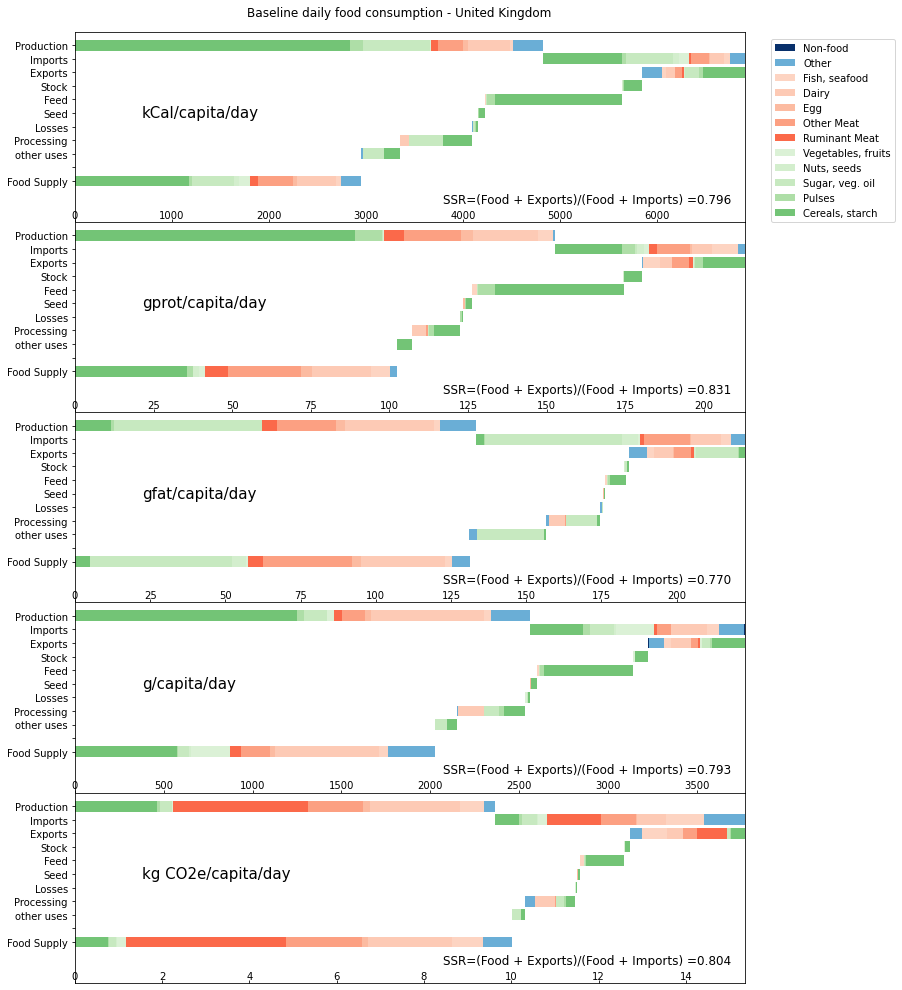

In [14]:
element = {"Production":0,
                "Imports":1,
                "Exports":2,
                "Stock":3,
                "Feed":4,
                "Seed":5,
                "Losses":6,
                "Processing":7,
                "other uses":8,
                "":9,
                "Food Supply":10
}

fig, ax = plt.subplots(len(labels),1,figsize=(12,len(labels)*3.5))
plt.subplots_adjust(hspace=0)

element_names = element.keys()
y_pos = element.items()

for iu in range(len(labels)):
    for ig in reversed(range(12)):
        ax[iu].barh(0, left = 0, width = np.cumsum(qtys[iu,0])[ig], color = colors[ig])
        ax[iu].barh(1, left = np.sum(qtys[iu,0]), width = np.cumsum(qtys[iu,1])[ig], color = colors[ig])

        for ib in range(2,9):
            ax[iu].barh(ib, left = np.sum(qtys[iu,:2]) - np.sum(qtys[iu,2:ib]), width = -np.cumsum(qtys[iu,ib])[ig], color = colors[ig])

        ax[iu].barh(10, left = 0, width=np.cumsum(qtys[iu,10])[ig], color = colors[ig], label = group_names[ig]) 

    SSR = np.sum(qtys[iu, [2,10]]) / np.sum(qtys[iu, [1,10]])
    ax[iu].text(0.55, 0.1, f'SSR=(Food + Exports)/(Food + Imports) ={SSR:.3f}', transform = ax[iu].transAxes, size=12)
    ax[iu].text(0.1, 0.55, labels[iu], transform = ax[iu].transAxes, size=15)
                
    ax[iu].set_yticks(np.arange(len(element_names)))
    ax[iu].tick_params(axis="x",direction="in", pad=-12)
    ax[iu].set_yticklabels(labels=element_names)
    ax[iu].invert_yaxis()  # labels read top-to-bottom
    ax[iu].set_ylim(13,-1)

plt.suptitle('Baseline daily food consumption - United Kingdom', y=0.90)
plt.legend(loc=(1.04,4))
plt.show()

In [15]:
# Fraction of actual production values for animal and plant food products
plant_production_scaling = 3
animal_production_scaling = 3

In [16]:
scaled_qtys = copy.deepcopy(qtys)

# Scale production
scaled_qtys[:, element["Production"], plant_mask] *= plant_production_scaling
scaled_qtys[:, element["Production"], animal_mask] *= animal_production_scaling

# Scale seed / feed
# less plant production means less need for plant seed
scaled_qtys[:, element["Seed"], plant_mask] *= plant_production_scaling
# Less animal production means less need for animal feed
scaled_qtys[:, element["Feed"], plant_mask] *= animal_production_scaling

# We compute the additional production values for each gropup
delta_plant = (scaled_qtys[:, element["Production"], plant_mask] - scaled_qtys[:, element["Seed"], plant_mask] - scaled_qtys[:, element["Feed"], plant_mask]) \
              - (qtys[:, element["Production"], plant_mask] - qtys[:, element["Seed"], plant_mask] - qtys[:, element["Feed"], plant_mask])
delta_animal = (scaled_qtys[:, element["Production"], animal_mask] - scaled_qtys[:, element["Feed"], animal_mask]) \
              - (qtys[:, element["Production"], animal_mask] - qtys[:, element["Feed"], animal_mask])

# And then subtract them from imports
scaled_qtys[:, element["Imports"], plant_mask] -= delta_plant
scaled_qtys[:, element["Imports"], animal_mask] -= delta_animal

In [17]:
# Auxiliary array to deal with extreme cases
imports = scaled_qtys[:, element["Imports"]]
exports = scaled_qtys[:, element["Exports"]]

# Add necesary reductions to exports
exports[imports < 0] -= imports[imports < 0]
imports[imports < 0] = 0

# Modify the arrays
scaled_qtys[:, element["Exports"]] = exports
scaled_qtys[:, element["Imports"]] = imports

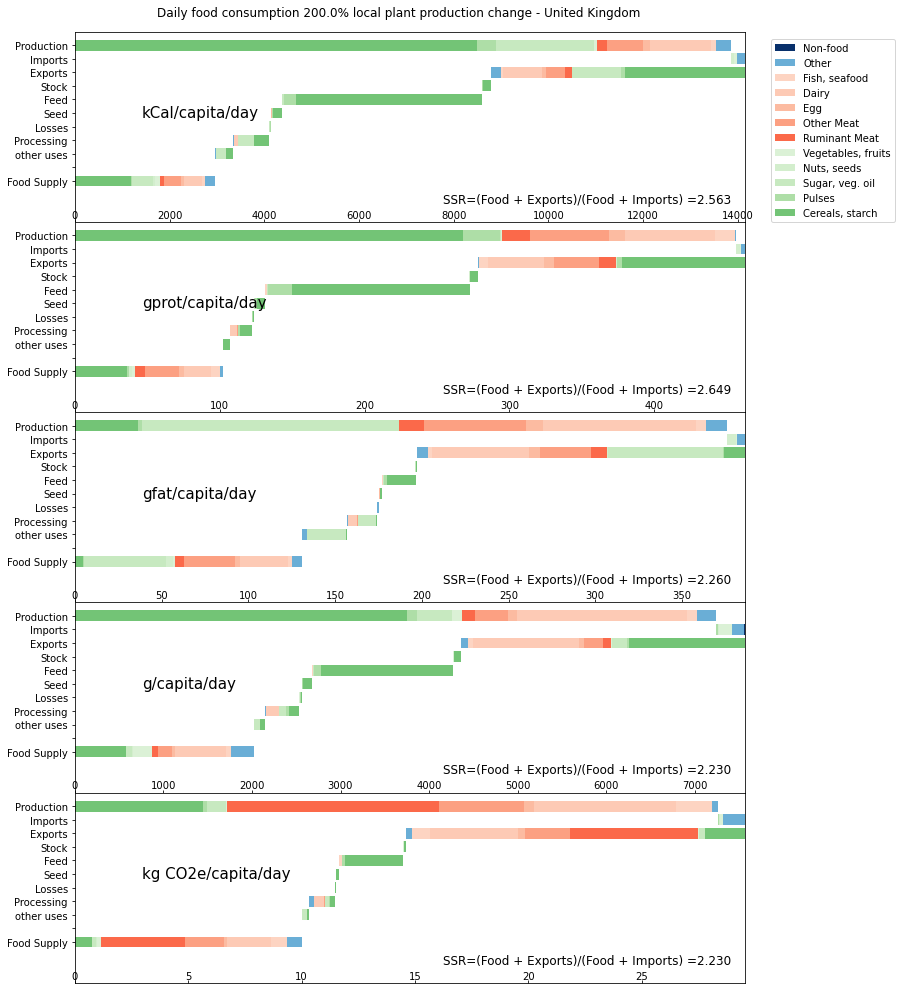

In [18]:
fig, ax = plt.subplots(len(labels),1,figsize=(12,len(labels)*3.5))
plt.subplots_adjust(hspace=0)

for iu in range(len(labels)):
    for ig in reversed(range(12)):
        ax[iu].barh(0, left = 0, width = np.cumsum(scaled_qtys[iu,0])[ig], color = colors[ig])
        ax[iu].barh(1, left = np.sum(scaled_qtys[iu,0]), width = np.cumsum(scaled_qtys[iu,1])[ig], color = colors[ig])

        for ib in range(2,9):
            ax[iu].barh(ib, left = np.sum(scaled_qtys[iu,:2]) - np.sum(scaled_qtys[iu,2:ib]), width = -np.cumsum(scaled_qtys[iu,ib])[ig], color = colors[ig])

        
        ax[iu].barh(10, left = 0, width=np.cumsum(scaled_qtys[iu,10])[ig], color = colors[ig], label = group_names[ig]) 
        
    SSR = np.sum(scaled_qtys[iu, [2,10]]) / np.sum(scaled_qtys[iu, [1,10]])
    ax[iu].text(0.55, 0.1, f'SSR=(Food + Exports)/(Food + Imports) ={SSR:.3f}', transform = ax[iu].transAxes, size=12)
    ax[iu].text(0.1, 0.55, labels[iu], transform = ax[iu].transAxes, size=15)
    
    ax[iu].set_yticks(np.arange(len(element_names)))
    ax[iu].tick_params(axis="x",direction="in", pad=-12)
    ax[iu].set_yticklabels(labels=element_names)
    ax[iu].invert_yaxis()  # labels read top-to-bottom
    ax[iu].set_ylim(13,-1)

plt.suptitle(f'Daily food consumption {(plant_production_scaling - 1)*100:.1f}% local plant production change - United Kingdom', y=0.90)
plt.legend(loc=(1.04,4.0))
plt.show()

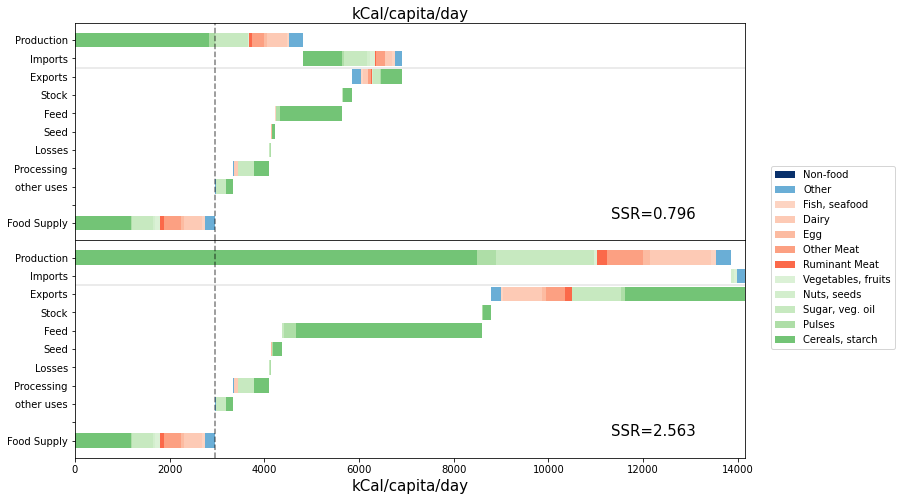

In [20]:
iel = 0 # kCal / capita / day
# iel = 1 # gprot / capita / day
# iel = 2 # gfat / capita / day
# iel = 3 # g / capita / day
# iel = 4 # kg CO2e / capita / day

fig, ax = plt.subplots(2,1,figsize=(12,2*4.0), sharex=True)
plt.subplots_adjust(hspace=0)

exqty = np.zeros((2, len(quantity_codes)-1, len(group_codes)))
exqty[0] = qtys[iel]
exqty[1] = scaled_qtys[iel]

for iu in range(2):
    for ig in reversed(range(12)):
        ax[iu].barh(0, left = 0, width = np.cumsum(exqty[iu,0])[ig], color = colors[ig])
        ax[iu].barh(1, left = np.sum(exqty[iu,0]), width = np.cumsum(exqty[iu,1])[ig], color = colors[ig])

        for ib in range(2,9):
            ax[iu].barh(ib, left = np.sum(exqty[iu,:2]) - np.sum(exqty[iu,2:ib]), width = -np.cumsum(exqty[iu,ib])[ig], color = colors[ig])

        ax[iu].barh(10, left = 0, width=np.cumsum(exqty[iu,10])[ig], color = colors[ig], label = group_names[ig]) 

    SSR = np.sum(exqty[iu, [2,10]]) / np.sum(exqty[iu, [1,10]])
    ax[iu].text(0.8, 0.1, f'SSR={SSR:.3f}', transform = ax[iu].transAxes, size=15)
        
    ax[iu].set_yticks(np.arange(len(element_names)))
    ax[iu].set_yticklabels(labels=element_names)
    ax[iu].invert_yaxis()  # labels read top-to-bottom
    ax[iu].set_xlabel(labels[iel], size=15)

    ax[iu].axvline(np.sum(exqty[iu, 10]), linestyle='dashed', color ='k', alpha=0.5)
    
    ax[iu].axhline(1.5, color = 'k', alpha=0.1)
    
ax[0].xaxis.set_label_position('top') 
    
# plt.suptitle('Daily food consumption - United Kingdom \n\n', y=0.90)
plt.legend(loc=(1.04,0.5))
plt.show()